In [1]:
import os
import zipfile
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

#Get Training and validation Data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
#unzip data
import os
import zipfile
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

#define data directory
training_data_dir = '/tmp/horse-or-human'
validation_data_dir = '/tmp/validation-horse-or-human'
#Create tarin and validation datagenerator
train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1/255.)
train_generator = train_data_gen.flow_from_directory(training_data_dir,
                                                     target_size=(150, 150),
                                                     batch_size=32,
                                                     class_mode='binary')
test_generator = test_data_gen.flow_from_directory(validation_data_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

--2021-01-26 10:55:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.2.112, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  94.8MB/s    in 1.5s    

2021-01-26 10:55:05 (94.8 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-01-26 10:55:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.7.144, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480

In [3]:
#Pretrained model
pre_trained_model = VGG16(include_top=False, input_shape=(150, 150, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
#block5_pool
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
#Define model
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

#train model
history = model.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10
33/33 [==============================] - 12s 344ms/step - loss: 63.1441 - accuracy: 0.6017 - val_loss: 1.5265 - val_accuracy: 0.7266
Epoch 2/10
33/33 [==============================] - 11s 337ms/step - loss: 1.2817 - accuracy: 0.8584 - val_loss: 0.3062 - val_accuracy: 0.9219
Epoch 3/10
33/33 [==============================] - 11s 336ms/step - loss: 1.0060 - accuracy: 0.8280 - val_loss: 0.0519 - val_accuracy: 0.9727
Epoch 4/10
33/33 [==============================] - 11s 334ms/step - loss: 0.4411 - accuracy: 0.9015 - val_loss: 0.4315 - val_accuracy: 0.8867
Epoch 5/10
33/33 [==============================] - 11s 335ms/step - loss: 0.8276 - accuracy: 0.8885 - val_loss: 1.6970 - val_accuracy: 0.8086
Epoch 6/10
33/33 [==============================] - 11s 334ms/step - loss: 0.5797 - accuracy: 0.8775 - val_loss: 0.0484 - val_accuracy: 0.9883
Epoch 7/10
33/33 [==============================] - 11s 334ms/step - loss: 0.4805 - accuracy: 0.8807 - val_loss: 0.3127 - val_accuracy: 0.941

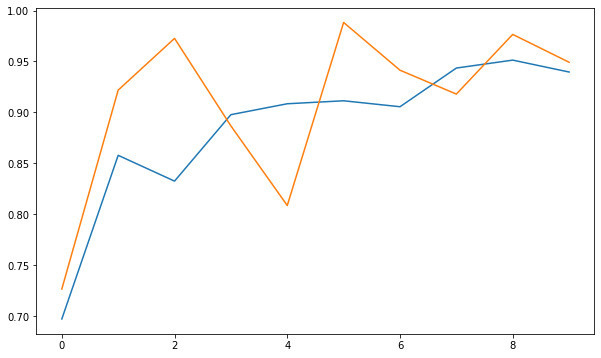

In [4]:
#Plot training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()